In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas_datareader as pdr

from trading_tools import MACD_Model

In [2]:
stock = yf.download('EBS.VI',start = "1980-01-01",end = "2025-01-01")

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

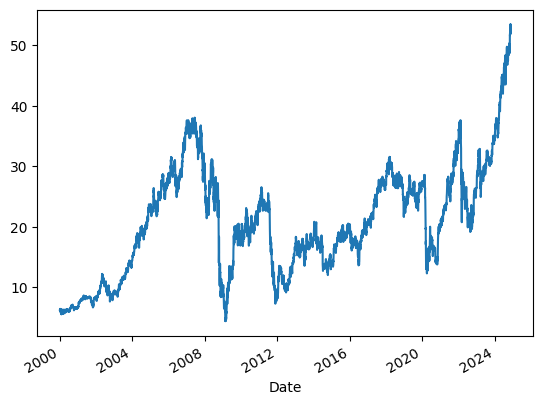

In [3]:
stock['Adj Close'].plot()

<Axes: xlabel='Date'>

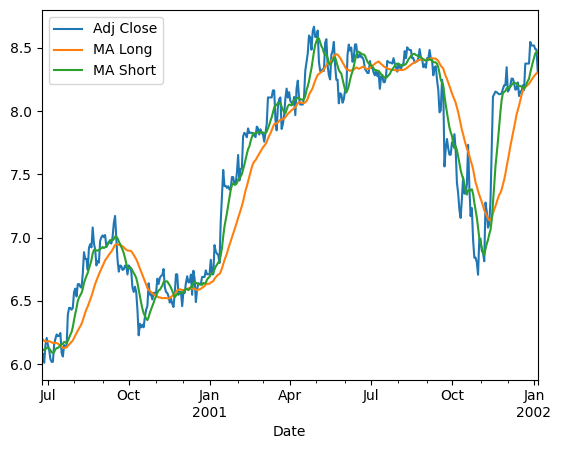

In [4]:
stock['MA Long'] = stock['Adj Close'].rolling(window=26).mean()
stock['MA Short'] = stock['Adj Close'].rolling(window=9).mean()
stock.dropna(inplace=True)
stock.iloc[100:500][['Adj Close','MA Long', 'MA Short']].plot()

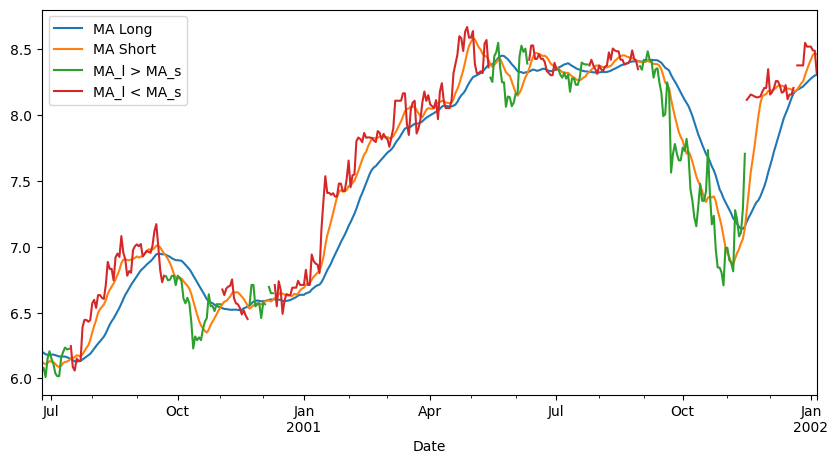

In [5]:
stock['MA_l > MA_s'] = np.where(stock['MA Long'] > stock['MA Short'], stock['Adj Close'], None)
stock['MA_l < MA_s'] = np.where(stock['MA Long'] < stock['MA Short'], stock['Adj Close'], None)
stock.iloc[100:500][['MA Long', 'MA Short', 'MA_l > MA_s', 'MA_l < MA_s']].plot(figsize=(10,5))
stock.drop(['MA_l < MA_s','MA_l > MA_s'],axis=1,inplace=True)

In [65]:
model = MACD_Model(stock)
# optimized_params = model.tune('2000','2012')

In [66]:
# PARAMS = np.round(optimized_params)[0]
PARAMS = [80,5]

In [67]:
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2014','2024')

In [68]:
metrics.ret,metrics.vol,metrics.sr

(0.047620367145262854, 0.17033962102256123, 0.24979665224483147)

<Axes: xlabel='Date', ylabel='Capital'>

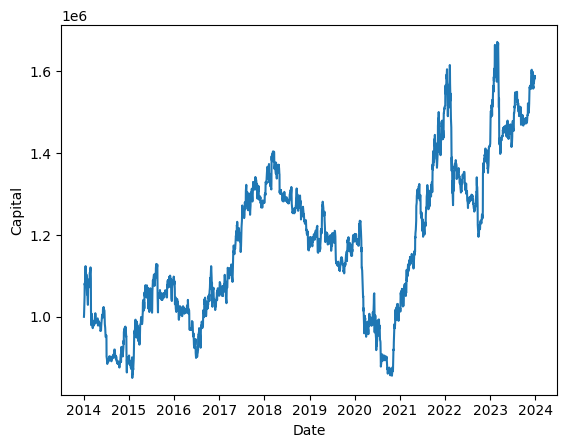

In [69]:
sns.lineplot(simulation_results,x=simulation_results.index,y='Capital')

[*********************100%***********************]  1 of 1 completed


(0.06964334253521987, 0.34434690933896167, 0.10060593429377439)

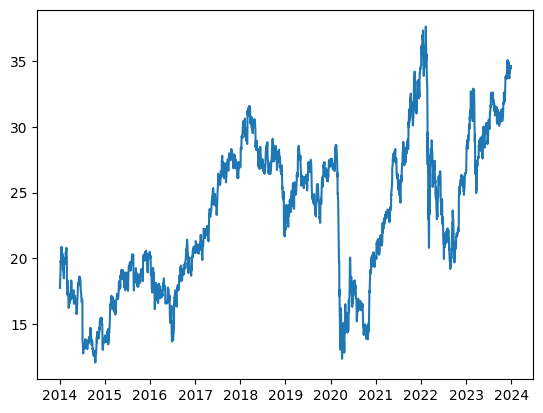

In [70]:
ebs_14_24 = yf.download('EBS.VI',start = "2014-01-01",end = "2024-01-01")
ret = ebs_14_24['Adj Close'].pct_change().dropna()

years = ebs_14_24.shape[0]/252
totret = (ret + 1).prod() - 1
annret = (1 + totret) ** (1 / years) - 1

vol = ret.std()
annvol = vol * np.sqrt(252)

rf = 0.035
sr =  (annret - rf) / annvol 

plt.plot(ebs_14_24['Adj Close'])
annret,annvol,sr

0.09756891377015986 0.2130631019809174 0.2752331257213192


[*********************100%***********************]  1 of 1 completed


0.033970210790990496 0.4343314262822638 -0.0023709755884444494


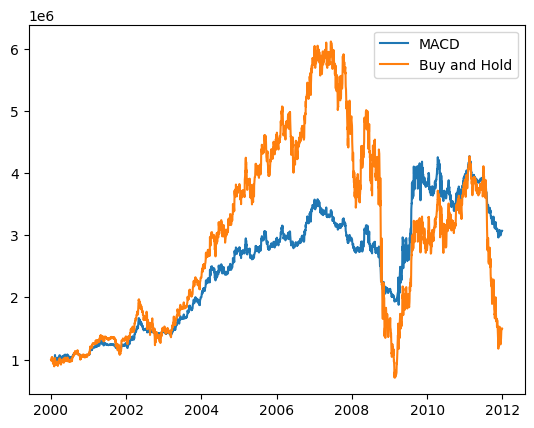

In [71]:
model = MACD_Model(stock)
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2000','2012')
print(metrics.ret,metrics.vol,metrics.sr)
plt.plot(simulation_results['Capital'],label='MACD')

ebs_14_24 = yf.download('EBS.VI',start = "2000-01-01",end = "2012-01-01")
ret = ebs_14_24['Adj Close'].pct_change().dropna()

years = ebs_14_24.shape[0]/252
totret = (ret + 1).prod() - 1
annret = (1 + totret) ** (1 / years) - 1

vol = ret.std()
annvol = vol * np.sqrt(252)

rf = 0.035
sr =  (annret - rf) / annvol 

plt.plot(ebs_14_24['Adj Close']/ebs_14_24['Adj Close'].iloc[0]*1000000,label='Buy and Hold')
plt.legend()
print(annret,annvol,sr)

In [11]:
def simulate_MC(x,mu,sigma,t=252,dt=1): 
    X_t = x
    drift = mu*dt 
    eps = np.random.normal(mu,sigma,t)
    res = []
    for i in range(t):
        diff = sigma*eps[i]*np.sqrt(dt)
        X_t_dt = X_t*np.exp(drift+diff-sigma**2/2)
        res.append(X_t_dt)
        X_t = X_t_dt
    return res 

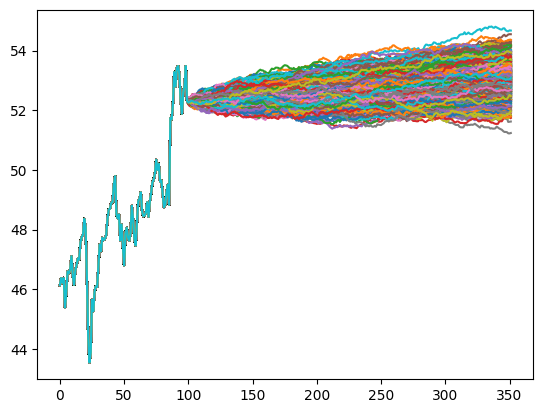

In [12]:
stock_pred=stock.iloc[:,-100:].copy()
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

for _ in range(1000):
    stock_pred=stock.iloc[-100:]['Adj Close'].copy()
    stock_pred = pd.concat([stock_pred,pd.Series(simulate_MC(x,mu,sigma))])
    stock_pred.reset_index(drop=True).plot()

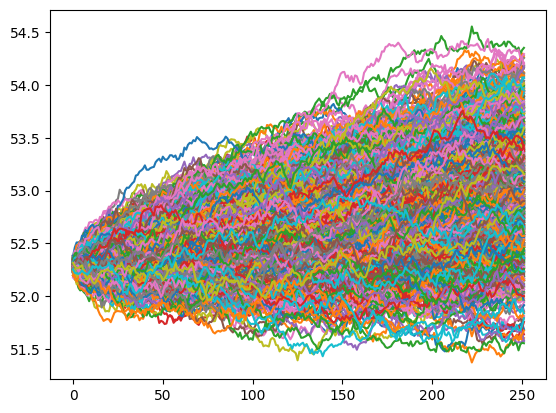

In [13]:
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

for _ in range(1000):
    plt.plot(simulate_MC(x,mu,sigma))

In [14]:
model = MACD_Model(stock)
model.set_params(PARAMS)
simulation_results,_ = model.run_simulation('2000','2024')

<Axes: xlabel='Date'>

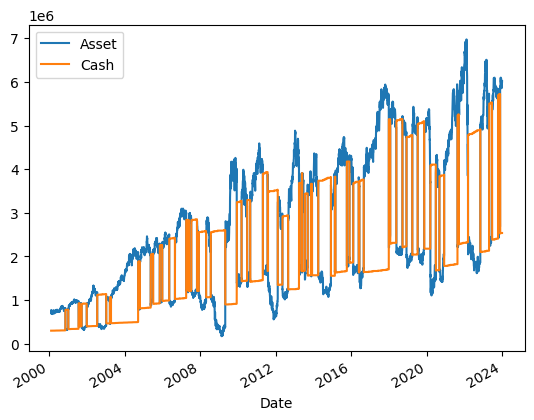

In [15]:
simulation_results[['Asset','Cash']].plot()

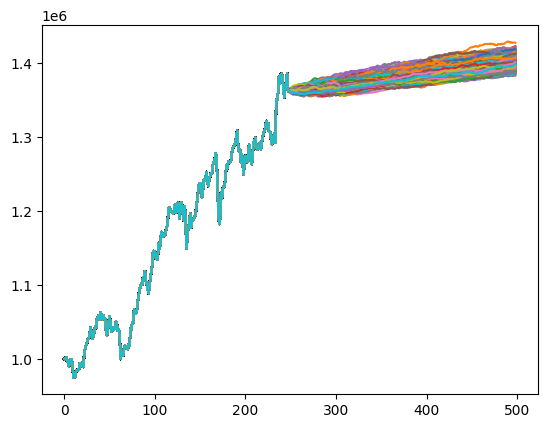

In [16]:
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

def var_historic(data: pd.DataFrame, level = 99):
    return -np.percentile(data, (100 - level))
def cvar_historic(data: pd.DataFrame, level = 99):
    is_beyond = data <= -var_historic(data, level = level)
    return -data[is_beyond].mean()

returns = []
var_cvar = []

for _ in range(1000):
    gen_df = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma)})
    df = pd.concat([stock.reset_index(), gen_df])[-500:-1].reset_index()[['Adj Close']]
    model_mc = MACD_Model(df)
    model_mc.set_params(PARAMS)
    model_mc.ir_const = True
    sim,_ = model_mc.run_simulation()
    var_cvar.append([var_historic(sim.pct_change().dropna()),cvar_historic(sim.pct_change().dropna())])
    returns.append(-model_mc.calculate_metrics('return'))
    sim['Capital'].plot()

(array([  2.64251971,   7.92755912,   7.92755912,  15.85511824,
         50.20787444,  88.52441019, 105.70078829, 128.1622058 ,
        117.59212697, 140.05354448, 146.65984375, 108.343308  ,
        103.05826858,  95.13070946,  71.34803209,  42.28031532,
         29.06771678,  22.46141751,  13.21259854,   9.24881898,
          6.60629927,   5.28503941,   2.64251971,   0.        ,
          1.32125985]),
 array([0.17802138, 0.17877823, 0.17953508, 0.18029194, 0.18104879,
        0.18180564, 0.1825625 , 0.18331935, 0.1840762 , 0.18483306,
        0.18558991, 0.18634676, 0.18710362, 0.18786047, 0.18861732,
        0.18937418, 0.19013103, 0.19088788, 0.19164474, 0.19240159,
        0.19315844, 0.1939153 , 0.19467215, 0.195429  , 0.19618586,
        0.19694271]),
 <BarContainer object of 25 artists>)

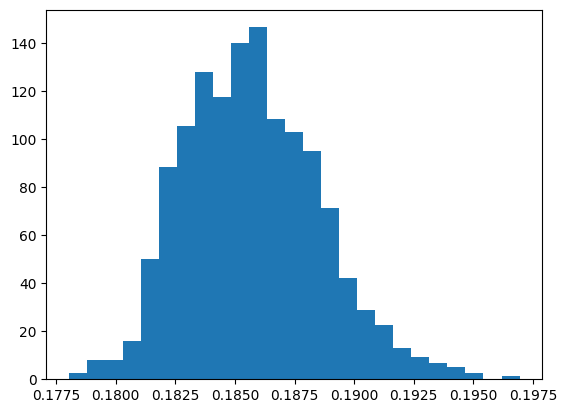

In [17]:
plt.hist(returns,25,density=1)

In [18]:
var_historic(simulation_results['Capital'].pct_change().dropna()).round(3)

0.032

In [19]:
cvar_historic(simulation_results['Capital'].pct_change().dropna()).round(3)

0.048

In [20]:
from datetime import date
today = date.today()

In [21]:
def transform_returns(data,n_cols):
    n_rows = int(np.ceil(len(data) / n_cols))
    total_elements = n_rows * n_cols
    padded_vector = np.pad(data, (0, total_elements - len(data)), 'constant')
    r = padded_vector.reshape(n_rows, n_cols).T
    ret = np.prod(r+1,axis=0) ** (1/252) -1
    return ret 

In [22]:
dax = yf.download('DAX',start = '2015-01-01',end = today)
dax['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


Date
2015-01-05   -0.049039
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08    0.028135
2015-01-09    0.000000
                ...   
2024-11-13   -0.013653
2024-11-14    0.011381
2024-11-15    0.000608
2024-11-18    0.002432
2024-11-19   -0.008490
Name: Adj Close, Length: 2487, dtype: float64

In [23]:
dax[dax.index >= '2024'].shape[0]

224

In [24]:
dax_r = np.array(dax['Adj Close'].pct_change().dropna())
ret_m = transform_returns(dax_r,252)

In [25]:
ebs = yf.download('EBS.VI',start = "2015-01-01",end = today)
ebs_r = np.array(ebs['Adj Close'].pct_change().dropna())

ret = transform_returns(ebs_r,252)

[*********************100%***********************]  1 of 1 completed


In [26]:
rf = pd.DataFrame(pdr.DataReader('FEDFUNDS', 'fred',start = "2015-01-01",end = today) / 100)
rf

,FEDFUNDS
DATE,
2015-01-01,0.0011
2015-02-01,0.0011
2015-03-01,0.0011
2015-04-01,0.0012
2015-05-01,0.0012
...,...
2024-06-01,0.0533
2024-07-01,0.0533
2024-08-01,0.0533


In [27]:
rf_r = transform_returns(rf.FEDFUNDS,12)

In [28]:
adj_a_r = ret - rf_r
adj_m_r = ret_m - rf_r

In [29]:
b, residuals, rank, s = np.linalg.lstsq(np.atleast_2d(adj_m_r).T, np.atleast_2d(adj_a_r).T, rcond=None)

In [30]:
BETA = b[0,0]
BETA

0.7505449005679808

In [31]:
r_m_last = ret_m[-1]
r_f_last = rf.iloc[-1].FEDFUNDS

In [32]:
def get_rf(bp,p,n_path): 
    v = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])
    dist = v * bp * 1e-4 
    return dist + (r_f_last+1)**(1/252) - 1 
get_rf(25,0.6,1000) 

array([[0.0026872, 0.0026872],
       [0.0026872, 0.0026872],
       [0.0026872, 0.0026872],
       ...,
       [0.0026872, 0.0026872],
       [0.0026872, 0.0001872],
       [0.0026872, 0.0001872]])

In [33]:
def fed_sim(bp,p,n_path): 

    rf = get_rf(bp,p,n_path)

    mu = ((ebs['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
    sigma = ebs['Adj Close'].pct_change().dropna().std()
    capital = []
    asset = []
    for i in range(n_path):

        m = rf[i] + BETA * ((r_m_last+1)**(1/dax[dax.index >= '2024'].shape[0])-1-rf[i])

        x = ebs.iloc[-1]['Adj Close']
        df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
        x = df1['Adj Close'].iloc[-1]

        x += x*m[0]

        df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
        x = df2['Adj Close'].iloc[-1]

        x += x*m[1]

        df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})


        gen_df = pd.concat([ebs[-200:],df1,df2,df3]).reset_index()
        gen_df['MA Long'] = gen_df['Adj Close'].rolling(window=int(PARAMS[0])).mean()
        gen_df['MA Short'] = gen_df['Adj Close'].rolling(window=int(PARAMS[1])).mean()
        gen_df = gen_df[200:].reset_index(drop=True)

        asset.append(list(gen_df['Adj Close']))

        model_mc = MACD_Model()
        model_mc.ir_const = True 
        model_mc.ir = r_f_last

        
        sim1,_ = model_mc.run_simulation(data=gen_df[:84])
        model_mc.ir = m[0]

        sim2,_ = model_mc.run_simulation(data=gen_df[84:168])
        model_mc.ir = m[1]

        sim3,_ = model_mc.run_simulation(data=gen_df[168:])
        sim_df = pd.concat([sim1,sim2,sim3]).reset_index(drop=True)

        capital.append(sim_df['Capital'])
        plt.plot(sim_df['Capital'])

    return np.array(capital),np.array(asset)

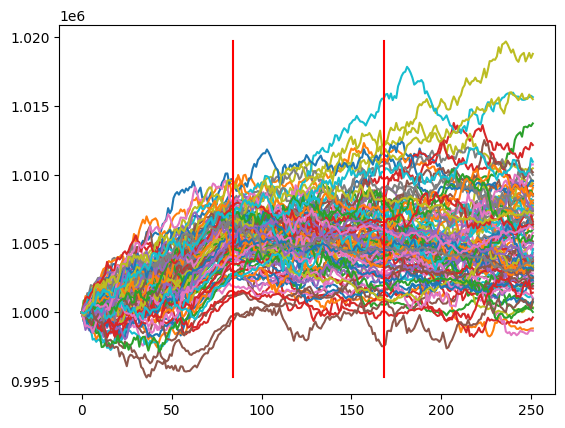

In [34]:
cap,_ = fed_sim(100,0.6,100)
plt.plot([84,84],[cap.min(),cap.max()],c='r')
plt.plot([168,168],[cap.min(),cap.max()],c='r')

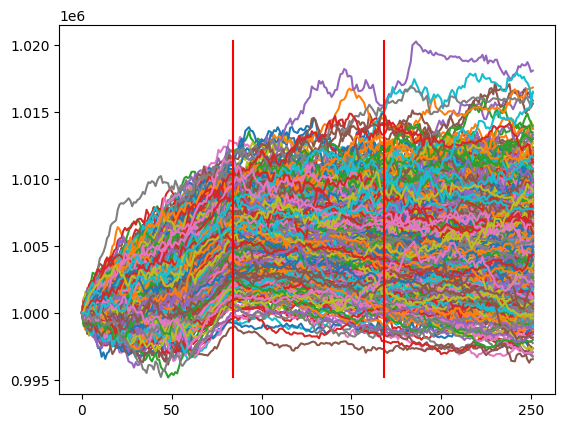

In [35]:
cap,asset = fed_sim(-100,0.7,1000)
plt.plot([84,84],[cap.min(),cap.max()],c='r')
plt.plot([168,168],[cap.min(),cap.max()],c='r')

In [36]:
# def fed_sim(bp,p,n_path): 
#     dist = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])

#     mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
#     sigma = stock['Adj Close'].pct_change().dropna().std()
#     results = []
#     for i in range(n_path):
        
#         x = stock.iloc[-1]['Adj Close']
#         df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df1['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df2['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})

#         gen_df = pd.concat([df1,df2,df3]).reset_index()
#         results.append(list(gen_df['Adj Close']))
#         gen_df['Adj Close'].plot()

#     result = np.array(results)

#     plt.plot([84,84],[result.min(),result.max()],c='r')
#     plt.plot([168,168],[result.min(),result.max()],c='r')

#     return result

In [37]:
# def fed_sim_model(bp,p,n_path): 
#     dist = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])

#     mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
#     sigma = stock['Adj Close'].pct_change().dropna().std()
#     for i in range(n_path):
        
#         x = stock.iloc[-1]['Adj Close']
#         df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df1['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df2['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})

#         gen_df = pd.concat([df1,df2,df3]).reset_index()

#         model_mc = MACD_Model(gen_df)
#         model_mc.set_params([200,5])
#         sim,_,_ = model_mc.run_simulation(0,-1)
#         sim['Capital'].plot()

#     plt.plot([84,84],[9.9e5,10.5e5])
#     plt.plot([168,168],[9.9e5,10.5e5])